In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Directories to save the images and 1D vectors
output_dir_images = 'images'
os.makedirs(output_dir_images, exist_ok=True)

output_dir_vectors = '1D'
os.makedirs(output_dir_vectors, exist_ok=True)

# Radial grid setup
r = np.linspace(-10, 10, 500)  # Radial distance
theta = np.linspace(0, 2 * np.pi, 500)  # Angular coordinate
R, Theta = np.meshgrid(r, theta)

# Generate and save plots for different frequencies
frequencies = np.linspace(1, 10, 500)  # 50 different frequencies
for idx, freq in enumerate(frequencies):
    Z = np.sin(freq * R)  # Frequency-modulated sine function

    # Convert polar to Cartesian coordinates
    X = R * np.cos(Theta)
    Y = R * np.sin(Theta)

    # Create the plot
    plt.figure(figsize=(5.12, 5.12), dpi=100)  # Set size to 512x512 pixels
    plt.contourf(X, Y, Z, levels=50, cmap='viridis')
    plt.axis('off')  # Remove all axes, grid, and elements

    # Save the plot as an image
    filename_image = os.path.join(output_dir_images, f'sine_frequency_{idx+1:02d}.png')
    plt.savefig(filename_image, bbox_inches='tight', pad_inches=0)
    plt.close()

    # Save the 1D vector representation of Z
    vector_filename = os.path.join(output_dir_vectors, f'sine_frequency_{idx+1:02d}.npy')
    np.save(vector_filename, Z.flatten())

print(f"Generated and saved {len(frequencies)} images in the '{output_dir_images}' directory.")
print(f"Generated and saved {len(frequencies)} 1D vectors in the '{output_dir_vectors}' directory.")


Generated and saved 500 images in the 'images' directory.
Generated and saved 500 1D vectors in the '1D' directory.


Training Sparse Autoencoder for 2D Images...


Epoch 20/20: 100%|██████████| 16/16 [00:01<00:00,  8.16it/s, loss=0.0432]


Training Sparse Autoencoder for 1D Vectors...


Epoch 20/20: 100%|██████████| 16/16 [00:00<00:00, 18.69it/s, loss=0.499]


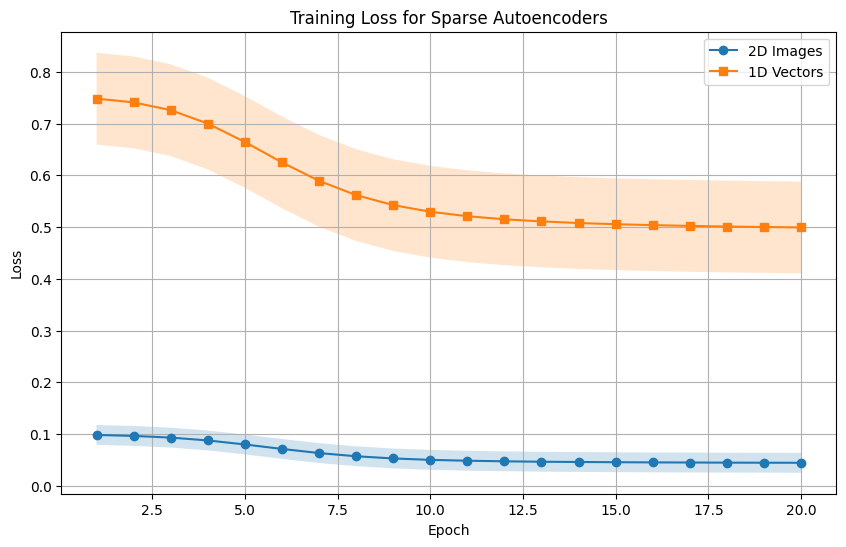

Models, neuron matrices, and loss plot saved.


In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image

# Define the sparse autoencoder class
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.Tanh(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.Tanh(),
            nn.Linear(hidden_dims[1], hidden_dims[2]),
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dims[2], hidden_dims[1]),
            nn.Tanh(),
            nn.Linear(hidden_dims[1], hidden_dims[0]),
            nn.Tanh(),
            nn.Linear(hidden_dims[0], input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Define a custom dataset for 2D images
class ImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        img = Image.open(self.data_files[idx]).convert('L')  # Convert to grayscale
        if self.transform:
            img = self.transform(img)
        return img

# Define a custom dataset for 1D vectors
class VectorDataset(Dataset):
    def __init__(self, data_dir):
        self.data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.npy')]

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        vector = np.load(self.data_files[idx]).astype(np.float32)
        return torch.tensor(vector)

# Parameters
image_dir = 'images'
vector_dir = '1D'
batch_size = 32
learning_rate = 1e-4
num_epochs = 20
hidden_dims = [128, 64, 32]
rho = 0.1  # Larger desired average activation for sparsity
beta = 1e-4  # Reduced sparsity penalty weight

# Training function
def train_autoencoder(model, dataloader, criterion, optimizer, device, num_epochs, rho, beta):
    model.train()
    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch in progress_bar:
            batch = batch.view(batch.size(0), -1).to(device)

            # Forward pass
            encoded, decoded = model(batch)
            mse_loss = criterion(decoded, batch)

            # Sparsity penalty
            rho_hat = torch.mean(encoded, dim=0)
            rho_hat = torch.clamp(rho_hat, 1e-6, 1 - 1e-6)  # Clamp to avoid instability
            sparsity_loss = rho * torch.log(rho / rho_hat) + (1 - rho) * torch.log((1 - rho) / (1 - rho_hat))
            sparsity_loss = sparsity_loss.mean()

            loss = mse_loss + beta * sparsity_loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        losses.append(epoch_loss / len(dataloader))

    return losses

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare datasets and dataloaders
# 2D Images
dataset_2d = ImageDataset(
    data_dir=image_dir,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)
dataloader_2d = DataLoader(dataset_2d, batch_size=batch_size, shuffle=True)

# 1D Vectors
dataset_1d = VectorDataset(data_dir=vector_dir)
dataloader_1d = DataLoader(dataset_1d, batch_size=batch_size, shuffle=True)

# Instantiate models
input_dim_2d = dataset_2d[0].numel()
input_dim_1d = dataset_1d[0].numel()

model_2d = SparseAutoencoder(input_dim_2d, hidden_dims).to(device)
model_1d = SparseAutoencoder(input_dim_1d, hidden_dims).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer_2d = optim.Adam(model_2d.parameters(), lr=learning_rate)
optimizer_1d = optim.Adam(model_1d.parameters(), lr=learning_rate)

# Train the models
print("Training Sparse Autoencoder for 2D Images...")
losses_2d = train_autoencoder(model_2d, dataloader_2d, criterion, optimizer_2d, device, num_epochs, rho, beta)

print("Training Sparse Autoencoder for 1D Vectors...")
losses_1d = train_autoencoder(model_1d, dataloader_1d, criterion, optimizer_1d, device, num_epochs, rho, beta)

# Save neuron matrices
os.makedirs('neuron_matrices', exist_ok=True)

# Save encoder weights for 2D model
for i, param in enumerate(model_2d.encoder.parameters()):
    np.save(f'neuron_matrices/encoder_2d_layer_{i}.npy', param.cpu().detach().numpy())

# Save decoder weights for 2D model
for i, param in enumerate(model_2d.decoder.parameters()):
    np.save(f'neuron_matrices/decoder_2d_layer_{i}.npy', param.cpu().detach().numpy())

# Save encoder weights for 1D model
for i, param in enumerate(model_1d.encoder.parameters()):
    np.save(f'neuron_matrices/encoder_1d_layer_{i}.npy', param.cpu().detach().numpy())

# Save decoder weights for 1D model
for i, param in enumerate(model_1d.decoder.parameters()):
    np.save(f'neuron_matrices/decoder_1d_layer_{i}.npy', param.cpu().detach().numpy())

# Plot training losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), losses_2d, label="2D Images", marker="o")
plt.plot(range(1, num_epochs + 1), losses_1d, label="1D Vectors", marker="s")
plt.fill_between(range(1, num_epochs + 1), np.array(losses_2d) - np.std(losses_2d), np.array(losses_2d) + np.std(losses_2d), alpha=0.2)
plt.fill_between(range(1, num_epochs + 1), np.array(losses_1d) - np.std(losses_1d), np.array(losses_1d) + np.std(losses_1d), alpha=0.2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss for Sparse Autoencoders")
plt.legend()
plt.grid(True)
plt.savefig('training_losses_comparison.png')
plt.show()

# Save models
os.makedirs('models', exist_ok=True)
torch.save(model_2d.state_dict(), 'models/sparse_autoencoder_2d.pth')
torch.save(model_1d.state_dict(), 'models/sparse_autoencoder_1d.pth')

print("Models, neuron matrices, and loss plot saved.")


Loading and visualizing weights for 2D Autoencoder...


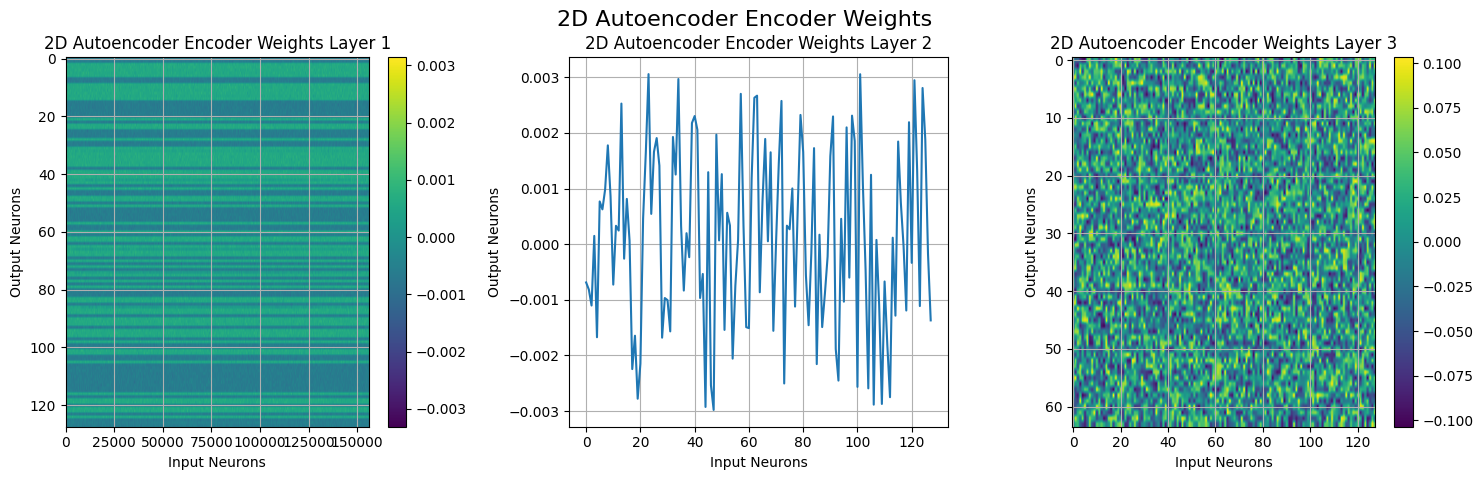

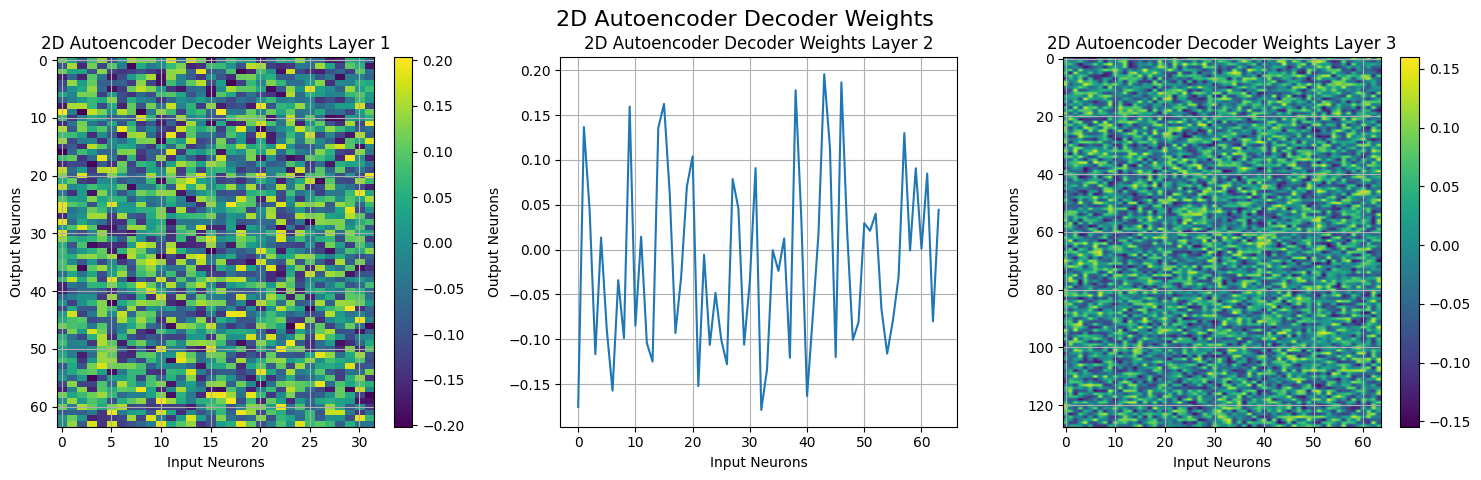

Loading and visualizing weights for 1D Autoencoder...


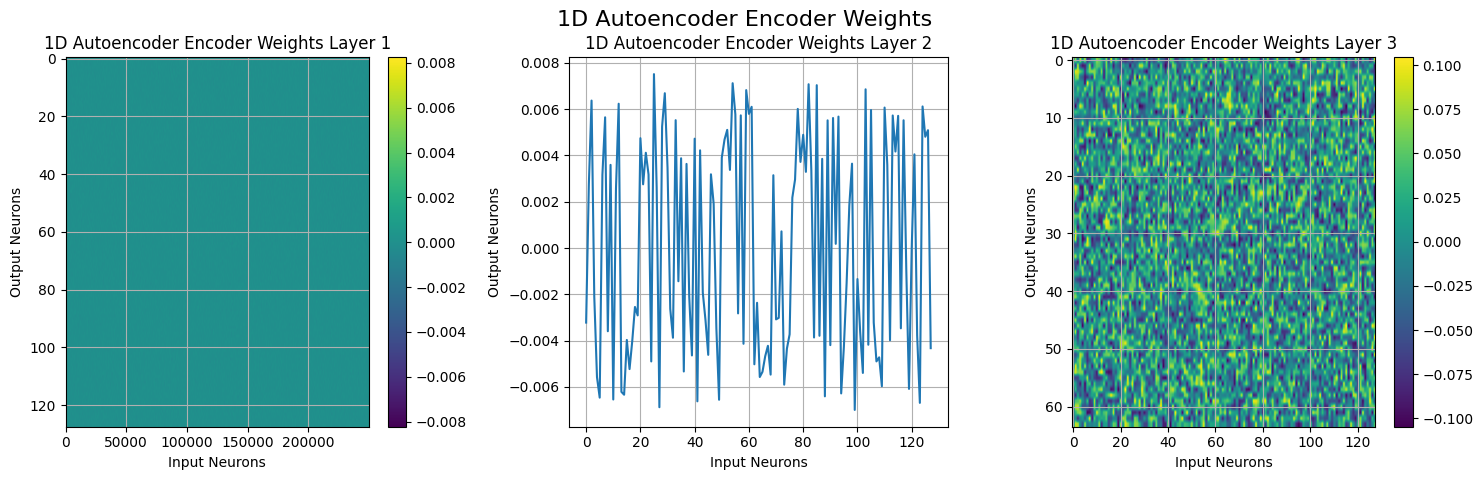

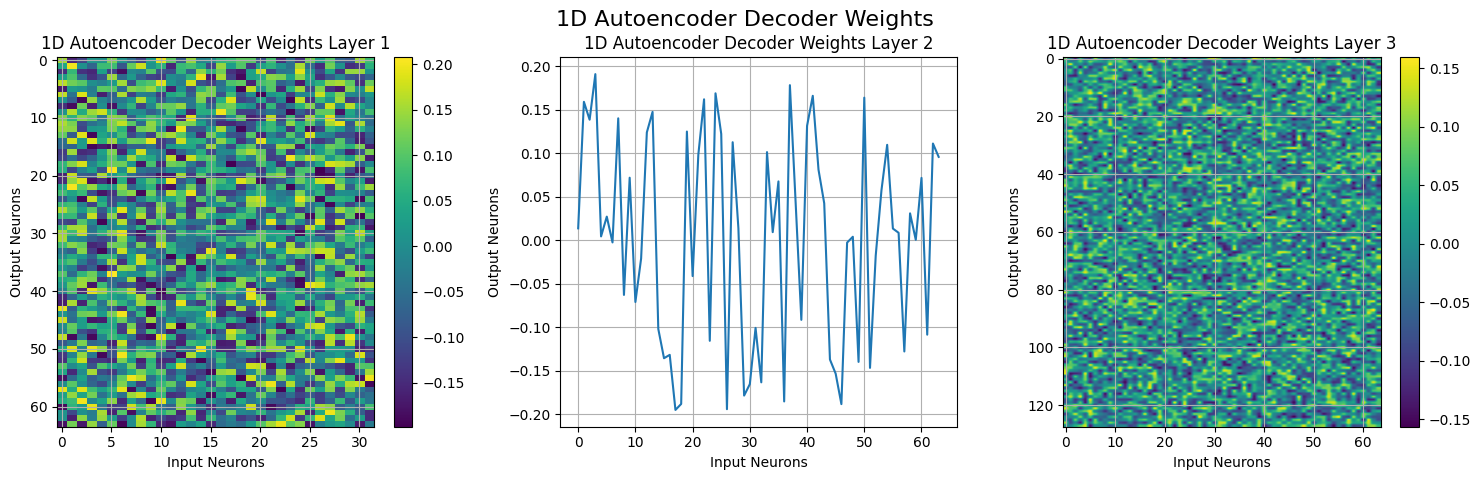

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Load all neuron matrices for a specific autoencoder
def load_weights(model_type, num_layers):
    weights = []
    for i in range(num_layers):
        file_path = f'neuron_matrices/{model_type}_layer_{i}.npy'
        if os.path.exists(file_path):
            weights.append(np.load(file_path))
        else:
            print(f"Warning: File {file_path} does not exist.")
    return weights

# Function to plot weights in a grid layout
def plot_weights_grid(weights, title, n_cols=3):
    n_layers = len(weights)
    n_rows = (n_layers + n_cols - 1) // n_cols  # Calculate the number of rows needed
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()  # Flatten the axes for easy indexing

    for i, weight in enumerate(weights):
        ax = axes[i]
        if weight.ndim == 2:  # Plot 2D weight matrix as a heatmap
            im = ax.imshow(weight, aspect='auto', cmap='viridis')
            plt.colorbar(im, ax=ax)
        else:  # Plot 1D weight vector as a line
            ax.plot(weight)
        ax.set_title(f"{title} Layer {i + 1}")
        ax.set_xlabel("Input Neurons")
        ax.set_ylabel("Output Neurons")
        ax.grid(True)

    # Turn off unused subplots
    for i in range(len(weights), len(axes)):
        axes[i].axis('off')

    plt.suptitle(title, fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

# Load and visualize weights for 2D autoencoder
print("Loading and visualizing weights for 2D Autoencoder...")
encoder_weights_2d = load_weights('encoder_2d', len(hidden_dims))
decoder_weights_2d = load_weights('decoder_2d', len(hidden_dims))
plot_weights_grid(encoder_weights_2d, "2D Autoencoder Encoder Weights")
plot_weights_grid(decoder_weights_2d, "2D Autoencoder Decoder Weights")

# Load and visualize weights for 1D autoencoder
print("Loading and visualizing weights for 1D Autoencoder...")
encoder_weights_1d = load_weights('encoder_1d', len(hidden_dims))
decoder_weights_1d = load_weights('decoder_1d', len(hidden_dims))
plot_weights_grid(encoder_weights_1d, "1D Autoencoder Encoder Weights")
plot_weights_grid(decoder_weights_1d, "1D Autoencoder Decoder Weights")
